## Artificial Intelligence - Computer Assignment 03: Clustering on Image
### Problem Description
In this assignment we're going to cluster images of 210 flowers and for that matter we're going to first extract features from images and then use different methods to cluster the images and at the end examine how good our method is.

First we import nessecary modules.

In [2]:
# Loading Image
import cv2

# Extracting Features
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.layers import Flatten
import numpy as np
from sklearn import preprocessing

# Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_distances

# Visualizing
import matplotlib.pyplot as plt

# Reducing Dimensions
from sklearn.decomposition import PCA

# Evaluation
from sklearn import metrics
import pandas as pd

### Preproccesing Data and Extracting Features
In order to cluster images, first we should turn our images to measurable data and extract some important features from each image to cluster them and determine which images are similar and which are not. For that maner I use VGG16 which is a pretrained convolutional neural network for image recognition. I load the pretraind network but without 3 fully connected layers(dense layers) in order to delete these 3 layers. 

In [ ]:
# VGG
vgg_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Loading Images and Extracting Features
features = []
for i in range(210):
    img = cv2.imread(f"flower_images/{i + 1:04d}.png")
    img = cv2.resize(img, (224, 224))
    img = np.array([img])
    img = preprocess_input(img) 
    feature = vgg_model.predict(img)
    feature = feature.flatten()
    features.append(feature)
features = preprocessing.normalize(features)


#### Q1. What is the reason for extracting features? Why don't we just read the pixels?
In clustering algorithms, the distance between data points is used to determine similarity but since images are high-dimensional data and the number of pixels can be very large, the distence measure can be unreliable. Also not every pixel in the image are important for distigusihing images and feature extraction helps to focus on important aspects of the image. Because of high-dimensionality clustering can become computationally expensive but with extracting features we reduce the dimensons so the process becomes faster and the result would be better. And feature extraction unlike raw data capture higher level concepts or semantic meaning from image like edge, texture, shape and color.

#### Q2. Search about feature extraction in image proccesing and explain 3 techniques of it.
Feature extraction in image processing is an important part of tasks like clustering, image recognition, and object detection. It involves transforming raw pixel data into a more informative representation that highlights the essential aspects of an image. One technique would be Histogram. It captures the distribution of pixel intensities in an image (grayscale) or across color channels (RGB). It's useful for analyzing overall brightness, contrast, and color distribution. Another technique would be Discrete Cosine Transform (DCT). It transforms the image from the spatial domain to the frequency domain. Often used in image compression, but DCT coefficients can also be used as features to capture spatial frequency information. And an important technique would be Convolutional Neural Networks (CNNs). They are trained on large image datasets and can automatically learn high-level features from images. These learned features can be very effective for various computer vision tasks. Pre-trained CNN models like VGG16 or ResNet can be used to extract features from new images.


#### Q3. What preprocessing should be done on images to make them ready for the model?
The most important preprocessing before getting images to VGG16 is resizing. VGG16 expects a specific input image size. Typically, it's pre-trained on images of size 224x224 pixels (width x height). We should resize images to match this dimension. Also color conversion is necessary because VGG16 is trained on RGB images and if images are in grayscale or another color format, we should convert them to RGB format.


### Implementing Clustering
Now that we preprocessed the images and features have been extracted, we can cluster our images.

#### Q4. Explain about K-Means and DBSCAN methods, their advantages and disadvantages.
K-Means is a centroid-based clustering algorithm.It first chooses k initial centroids (cluster centers). Then assigns each data point to the nearest centroid and update the centroids by calculating the mean of the points assigned to each cluster. It repeats this procedure until no centroid changes. DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a density-based clustering algorithm. It has two parameters. Eps(maximum distance between points to be considered neighbors) and MinPts(minimum number of neighbors a point needs to be considered a core point). The algorithm expands clusters by considering neighbors of core points(points having at least MinPts neighbors within Eps distance) that are also core points or reachable from core points through a chain of density-connected points. Kmeans is computationally efficient especially for large datasets but DBSCAN can be computationally more expensive. Kmeans reqiures number of clusters but DBSCAN doesn't need k and automatically discover the number of clusters based on the data density. Another disadvantage of kmeans is that outliers can significantly affect the position of centroids and bias the clustering results but DBSCAN is less sensitive to outliers compared to K-Means, as outliers are typically isolated points with low density.

#### K-means
Our first method is kmeans.

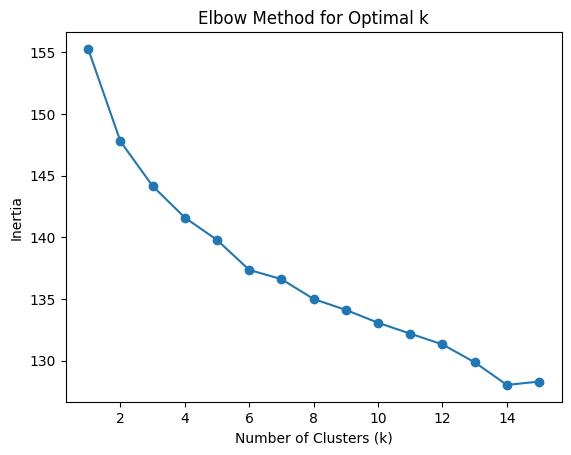

In [4]:
# Defining Parameters for K-means Clustering
MAX_K = 15
NUM_INIT = 10
NUM_GEN_CENT = 19

# Finding optimal k with elbow method
cluster_numbers = []
inertia = []
for k in range(1, MAX_K + 1):
    cluster_numbers.append(k)
    kmeans_model = KMeans(n_clusters=k, random_state=NUM_GEN_CENT, n_init=NUM_INIT)
    kmeans_model.fit(features)
    inertia.append(kmeans_model.inertia_)

plt.plot(cluster_numbers, inertia, marker = 'o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()

# Performing K-means algorithm
kmeans_model = KMeans(n_clusters=14, random_state=NUM_GEN_CENT, n_init=NUM_INIT)
kmeans_model.fit(features)
kmeans_label = kmeans_model.labels_

#### Q5. What method did you use to find optimal k in kmeans clustering algorithm?
I used the Elbow Method. Elbow Method is a technique that we use to determine the number of centroids(k) to use in a k-means clustering algorithm. In this method to determine the k-value we continuously iterate for k=1 to k=n which n is a hyperparameter and for every k, we calculate the inertia which is the sum of the squared distances of samples to their closest cluster center. Then we visualize the value of inertia for each k. To determine the optimal number of clusters, we select the value of k at the “elbow” that is the point after which the inertia starts decreasing in a linear way.

#### DBSCAN
The second method is DBSCAN.

In [5]:
# Defining Parameters for DBSACN Clustering
EPS = 0.54
MIN_SMPLS = 7

# Finding Optimal eps and min_samples
p = PCA(n_components=12)
p.fit(features)
new_features = p.transform(features)

# Using real label for comparison
df = pd.read_csv("flower_images/flower_labels.csv")
true_label = df['label']

# Decreasing dimensions
best_eps = 0
max_score = 0.3
eps_i = .2
while eps_i < 0.9:
    eps_i += 0.01
    dbscan_model = DBSCAN(eps=eps_i, min_samples=MIN_SMPLS, metric='chebyshev')
    dbscan_model.fit_predict(cosine_distances(new_features))
    dbscan_label = dbscan_model.labels_
    
    dbscan_homogeneity = metrics.homogeneity_score(true_label, dbscan_label)
    if dbscan_homogeneity > max_score:
        max_score = dbscan_homogeneity
        best_eps = eps_i
print(max_score)
print(best_eps)

# Performing DBSCAN algorithm
dbscan_model = DBSCAN(eps=EPS, min_samples=MIN_SMPLS, metric='chebyshev')
dbscan_model.fit(cosine_distances(new_features))
dbscan_label = dbscan_model.labels_
dbscan_homogeneity = metrics.homogeneity_score(true_label, dbscan_label)
print("number of clusters:", len(set(dbscan_label)))
print("dbscan_homogeneity:", dbscan_homogeneity)

0.4720454646478
0.5400000000000003
number of clusters: 8
dbscan_homogeneity: 0.4720454646478


#### Q6. Compare the output of two clustering methods.
Both algorithms cluster the images into groups. Both of their output is a list of labels which is a size of 210 and each index repreasents the label of that specefic flower with a number. K-means make 14 clusters and DBSCAN make 8 clusters. Furthur comparisons will be explained in the evaluation part.  

### Reducing Dimensions and Visualizing Clusters

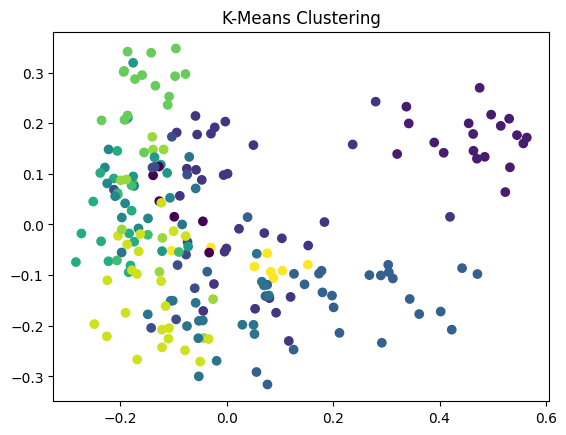

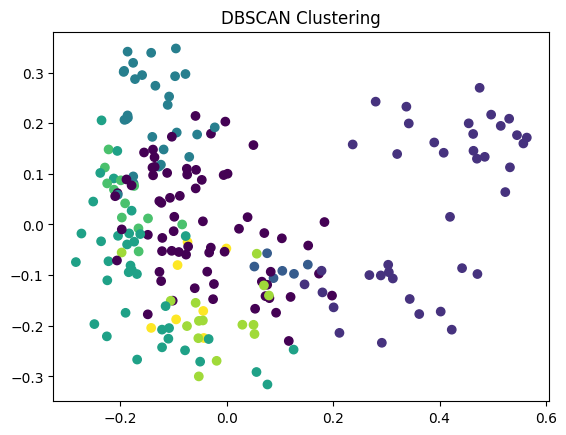

In [6]:
pca = PCA(n_components=2)
pca.fit(features)
pca_feat = pca.transform(features)
plt.scatter(pca_feat[:, 0], pca_feat[:, 1], c = kmeans_label)
plt.title("K-Means Clustering")
plt.show()
plt.scatter(pca_feat[:, 0], pca_feat[:, 1], c = dbscan_label)
plt.title("DBSCAN Clustering")
plt.show()

#### Search about PCA and explain its function.
Principal Component Analysis (PCA) is a dimensionality reduction technique commonly used in data analysis and machine learning. It transforms a dataset of high-dimensional data into a lower-dimensional representation while keeping the most important information. PCA works like this. With centering the data by subtracting the mean from each feature, ensures all features are on the same scale. Then the covariance matrix captures the linear relationships between all pairs of features. Decomposing the covariance matrix reveals its eigenvalues and eigenvectors. Eigenvalues are ranked in descending order. The top 'k' eigenvectors, corresponding to the highest eigenvalues, represent the principal components that capture the most variance. At last, the original data is projected onto the chosen principal components, resulting in a lower-dimensional representation that retains the most important information.

### Evaluation

#### Homogeneity Score

In [7]:
# Using real label for comparison
df = pd.read_csv("flower_images/flower_labels.csv")
true_label = df['label']

# Evaluating K-means Using Homogeneity Score
kmeans_homogeneity = metrics.homogeneity_score(true_label, kmeans_label)
kmeans_completeness = metrics.completeness_score(true_label, kmeans_label)
kmeans_v_measure = metrics.v_measure_score(true_label, kmeans_label)
print("[K-means]")
print("homogeneity_score:", kmeans_homogeneity)
print("completeness_score:", kmeans_completeness)
print("v_measure_score:", kmeans_v_measure, "\n")

# Evaluating DBSCAN Using Homogeneity Score
dbscan_homogeneity = metrics.homogeneity_score(true_label, dbscan_label)
dbscan_completeness = metrics.completeness_score(true_label, dbscan_label)
dbscan_v_measure = metrics.v_measure_score(true_label, dbscan_label)
print("[DBSCAN]")
print("homogeneity_score:", dbscan_homogeneity)
print("completeness_score:", dbscan_completeness)
print("v_measure_score:", dbscan_v_measure)

[K-means]
homogeneity_score: 0.6146271182628069
completeness_score: 0.5606144787726527
v_measure_score: 0.5863796217111683 

[DBSCAN]
homogeneity_score: 0.4720454646478
completeness_score: 0.5959272219003774
v_measure_score: 0.5268013796634607


#### Silhoutte Score

In [8]:
# Evaluating K-means Using Silhoutte Score
kmeans_silhouette_value = metrics.silhouette_score(features, kmeans_label)
print("[K-means]\nAverage Silhouette Score:", kmeans_silhouette_value, "\n")

# Evaluating DBSCAN Using Silhoutte Score
dbscan_silhouette_value = metrics.silhouette_score(features, dbscan_label)
print("[DBSCAN]\nAverage Silhouette Score:", dbscan_silhouette_value)


[K-means]
Average Silhouette Score: 0.023492924718884853 

[DBSCAN]
Average Silhouette Score: 0.02240376963564252


#### Q8. Explain how homogeneity and silhouette score are measured.
Homogeneity: Homogeneity measures how much each cluster in a clustering solution contains data points that belong to the same class label. It is particularly relevant when the true labels of the data points are known. Two common ways to calculate homogeneity are Rand Index and Jaccard Index. The Rand Index considers both true positives (correctly assigned data points) and true negatives (correctly unassigned data points between different classes). It ranges from 0 (totally random clustering) to 1 (perfect clustering where all data points within a cluster belong to the same class). The Jaccard Index focuses on the ratio of correctly assigned data points within a cluster (true positives) to the total number of points assigned to that cluster (including both true positives and false positives).
ON the other hand completeness measures how much all members of a given class are assigned to the same cluster. Completeness and homogeneity's harmonic mean is called V-measure.
Silhouette Score: The silhouette score measures how well data points are assigned to their clusters and how well-separated clusters are. It considers both the cohesion (similarity) within a cluster and the separation between clusters. The silhouette coefficient for each data point is calculated as (b - a) / max(a, b) where 'a' is the average intra-cluster distance and 'b' is the average inter-cluster distance for that data point. Intra-cluster distance is the average distance between each data point and all other data points within the same cluster and inter-cluster distance is the average distance between each data point and all data points in the nearest different cluster. The average silhouette score for the entire clustering solution is calculated as the mean of the silhouette coefficients for all data points.

#### Q9. Report the results of both criterias for each method.
 A high homogeneity score (close to 1) suggests that each cluster contains data points from a single class, indicating that the clustering algorithm successfully captures the underlying structure of the data. A low homogeneity score indicates that clusters may contain data points from different classes, implying that the algorithm has not effectively grouped similar data points together. For K-Means method, the homogeneity score was about 0.614 and for DBSCAN method, the homogeneity score was about 0.472. The results seems to be good enough.
In silhouette score measurement, values closer to +1 indicate well-separated clusters with data points well-assigned to their closest cluster. Values closer to 0 indicate data points on cluster borders, where the distinction is less clear. And negative values suggest data points might be misclassified and assigned to the wrong cluster. For K-Means method, the silhouette score was about 0.023 and for DBSCAN method, the silhouette score was about 0.022. The results seem not bad but it shows that the clusters may have overlaps.
#### Q10. Suggest solutions for improving the models.
We can try to ensure the data is accurate, consistent, and doesn't have noise. We can also pay more attention to preprocessing and apply better preprocessing techniques to prepare the data for modeling. We can fine-tune our model on a smaller dataset or on a specific subset of our data to improve performance on a targeted task. Transforming features into more suitable representations to improve the model's ability to learn patterns from the data would be another idea. Selecting an appropriate algorithm that aligns with the nature of the task and the characteristics of the data also would improve our model. We can also optimize the hyperparameters of the algorithm to find the best configuration that maximizes the model's performance.

